In [53]:
# !pip install efficientnet-pytorch sklearn pytorch-gradcam

<b>History of performance</b>

<u>ResNet50</u>
```
Epoch [20] [----] Accuracy=0.849 time: 9907.055, avg: 495.353
9910.68 seconds taken for model training
Saved the trained model: checkpoints/ResNet50-13082020-225751.pth.tar
```

Confusion Matrix:
```
[[812  71   2]
 [ 69 524   1]
 [ 15  47  38]]
 
Normalized:
[[0.91751412 0.08022599 0.00225989]
 [0.11616162 0.88215488 0.0016835 ]
 [0.15       0.47       0.38      ]]

Average precision:
{'normal': 0.9635609285949972,
 'pneumonia': 0.9167709627528383,
 'COVID-19': 0.7177274694611359}

```

<u>DenseNet169</u>
```
Epoch [20] [save] Accuracy=0.877 time: 10684.240, avg: 534.212
10692.20 seconds taken for model training
Saved the trained model: checkpoints/DenseNet169-13082020-160734.pth.tar

```

Confusion Matrix:
```
[[842  40   3]
 [ 82 501  11]
 [ 21  34  45]]
 
Normalized:
[[0.95141243 0.04519774 0.00338983]
 [0.13804714 0.84343434 0.01851852]
 [0.21       0.34       0.45      ]]

Average precision:
{'normal': 0.9693357502226474,
 'pneumonia': 0.926793498666849,
 'COVID-19': 0.6723035153267891}
```

<u>EfficientNet5</u>
```
Epoch [20] [save] Accuracy=0.829 time: 13919.191, avg: 695.960
13922.36 seconds taken for model training
Saved the trained model: checkpoints/EfficientNet5-13082020-190547.pth.tar

Confusion Matrix:

[[833  51   1]
 [126 468   0]
 [ 42  37  21]]
 
Normalized:
[[0.94124294 0.05762712 0.00112994]
 [0.21212121 0.78787879 0.        ]
 [0.42       0.37       0.21      ]]

Average precision:
{'normal': 0.9417960453705472,
 'pneumonia': 0.9044023769306659,
 'COVID-19': 0.53796939494876}

```

In [54]:
import os

import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from torchvision import transforms

import models
from dataset_generator import DatasetGenerator


In [55]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_resize = 256
image_crop = 224
batch_size = 64

class_to_idx = {
    'normal': 0,
    'pneumonia': 1,
    'COVID-19': 2
}

image_dir = 'data'
test_csv_file = 'test_split.txt'

# define test transforms
test_transforms = transforms.Compose([
    transforms.Resize(image_resize),
    transforms.CenterCrop(image_crop),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# define test dataset
test_dir = os.path.join(image_dir, 'test')
test_dataset = DatasetGenerator(test_csv_file, test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=16, shuffle=True)

In [58]:
!ls -ltrh checkpoints

total 795M
-rw-r--r-- 1 ubuntu ubuntu  55M Aug 13 19:05 DenseNet169-13082020-160734.pth.tar
-rw-r--r-- 1 ubuntu ubuntu 117M Aug 13 22:57 EfficientNet5-13082020-190547.pth.tar
-rw-r--r-- 1 ubuntu ubuntu  98M Aug 14 01:43 ResNet50-13082020-225751.pth.tar
-rw-rw-r-- 1 ubuntu ubuntu  31M Aug 17 21:47 DenseNet121-1597699937.pth.tar
-rw-rw-r-- 1 ubuntu ubuntu  98M Aug 17 22:09 ResNet50-1597701693.pth.tar
-rw-rw-r-- 1 ubuntu ubuntu 117M Aug 17 22:30 EfficientNet5-1597702792.pth.tar
-rw-rw-r-- 1 ubuntu ubuntu  55M Aug 18 00:28 DenseNet169-1597709583.pth.tar
-rw-r--r-- 1 ubuntu ubuntu  55M Aug 18 09:19 DenseNet169-18082020-062006.pth.tar
-rw-r--r-- 1 ubuntu ubuntu 171M Aug 18 13:38 ResNet101-18082020-095135.pth.tar


In [59]:
# load model
def load_pretrained_model(arch):
    model_func = getattr(models, arch)
    model = model_func()
    model.arch = arch

    return model

os.environ['HOME'] = '.'

In [60]:
# TBD load checkpoint file
ckp_path = 'checkpoints/EfficientNet5-13082020-190547.pth.tar'
model_checkpoint = torch.load(ckp_path, map_location=torch.device('cpu'))
state_dict = model_checkpoint['state_dict']
arch = model_checkpoint['arch']
pretrained_model = load_pretrained_model(arch)

# check the state dictionary matches
old_state_dict = pretrained_model.state_dict()
for k in state_dict:
    if k not in old_state_dict:
        print('Unexpected key %s in state_dict' % k)
for k in old_state_dict:
    if k not in state_dict:
        print('Missing key %s in state_dict' % k)

# TBD: load checkpoint into pretrained_model
pretrained_model.load_state_dict(state_dict)

Loaded pretrained weights for efficientnet-b5


<All keys matched successfully>

In [61]:
# do prediction for test dataset
pretrained_model.eval()

# append the prediction output using torch.cat
pred_out = torch.FloatTensor()
# append the labels
labels_list = []
with torch.no_grad():
    for images, labels in test_loader:
        # TBD append the labels
        labels_list.extend(labels)
        log_ps = pretrained_model.forward(images)
        ps = torch.exp(log_ps).squeeze()
        # TBD append the prediction output using torch.cat
        pred_out = torch.cat((pred_out,ps),0)
        if len(labels_list) % 128 == 0:
            print(len(labels_list), pred_out.shape)

128 torch.Size([128, 3])
256 torch.Size([256, 3])
384 torch.Size([384, 3])
512 torch.Size([512, 3])
640 torch.Size([640, 3])
768 torch.Size([768, 3])
896 torch.Size([896, 3])
1024 torch.Size([1024, 3])
1152 torch.Size([1152, 3])
1280 torch.Size([1280, 3])
1408 torch.Size([1408, 3])
1536 torch.Size([1536, 3])


In [62]:
precision = dict()
recall = dict()
average_precision = dict()

# https://github.com/rachellea/glassboxmedicine/blob/master/2020-07-14-AUROC-AP/main.py
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

# for each clz ('normal', 'pneumonia', 'COVID-19')
for clz in class_to_idx:
    clz_pred_out = pred_out[:,class_to_idx[clz]].numpy()
    # TBD calculate precision and recall curve and store in precision, recall
    precision[clz], recall[clz], _ = precision_recall_curve(y_true = labels_list,
                                                           probas_pred = clz_pred_out,
                                                           pos_label = clz)
    
    clz_labels_list = [clz == label for label in labels_list]
    # TBD calculate average precision score (the area under the curve)
    average_precision[clz] = average_precision_score(y_true=clz_labels_list,
                                                    y_score = clz_pred_out)

# TBD result looks like the following    
# {'normal': 0.9855985255902013,
#  'pneumonia': 0.9713300353762777,
#  'COVID-19': 0.8363362361594885}
average_precision

{'normal': 0.9417960453705472,
 'pneumonia': 0.9044023769306659,
 'COVID-19': 0.53796939494876}

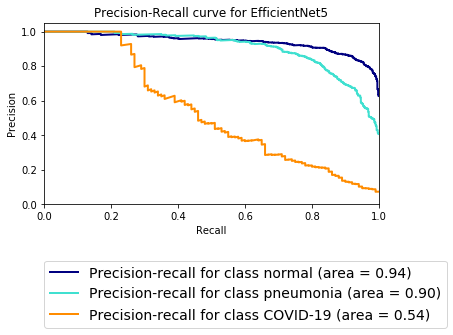

In [63]:
colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']

lines = []
labels = []

for clz in class_to_idx:
    l, = plt.plot(recall[clz], precision[clz], color=colors[class_to_idx[clz]], lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'.format(clz, average_precision[clz]))
    
fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for {}'.format(arch))
plt.legend(lines, labels, loc=(0, -.68), prop=dict(size=14))

plt.show()

In [64]:
# NOT USED
def confusion_matrix_values(y_true, y_score, decision_thresh):
    #Obtain binary predicted labels by applying <decision_thresh> to <y_score>
    y_pred = (np.array(y_score) > decision_thresh)
    cm = sklearn.metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    return true_neg, false_pos, false_neg, true_pos

In [65]:
# NOT USED
def calculate_tpr_fpr_prec(y_true, y_score, decision_thresh):
    true_neg, false_pos, false_neg, true_pos =  confusion_matrix_values(y_true, y_score, decision_thresh)
    tpr_recall = float(true_pos)/(true_pos + false_neg)
    fpr = float(false_pos)/(false_pos+true_neg)
    precision = float(true_pos)/(true_pos + false_pos)
    return tpr_recall, fpr, precision

In [66]:
max_pred_out = pred_out.max(dim=1)
max_pred_indices = max_pred_out.indices.numpy()
max_pred_vals = max_pred_out.values.numpy()

labels_indices = [class_to_idx[label] for label in labels_list]
cm = confusion_matrix(y_true = labels_indices, y_pred = max_pred_indices)
print(cm)


normalized_cm = confusion_matrix(y_true = labels_indices, y_pred = max_pred_indices, normalize = 'true')
print(normalized_cm)

[[833  51   1]
 [126 468   0]
 [ 42  37  21]]
[[0.94124294 0.05762712 0.00112994]
 [0.21212121 0.78787879 0.        ]
 [0.42       0.37       0.21      ]]


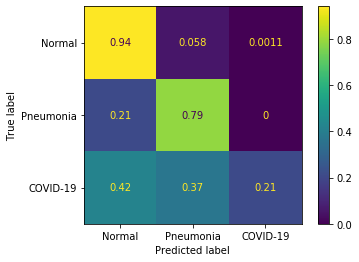

In [67]:
cm_display = ConfusionMatrixDisplay(normalized_cm, display_labels = np.array(['Normal','Pneumonia','COVID-19'])).plot()